# MagGeo v1.0 - Sequential Mode 

**Authors** | Fernando Benitez-Paez, Urška Demšar, Jed Long

**Contact**  | [Fernando.Benitez@st-andrews.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk), [ud2@st-andrews.ac.uk](mailto:ud2@st-andrews.ac.uk), <jed.long@uwo.ca>

**nbviewer URL** | https://nbviewer.jupyter.org/github/MagGeo/MagGeo-Annotation-Program/blob/master/MagGeo_Sequential.ipynb

**Keywords** | Bird migration, data fusion, Earth’s magnetic field, Swarm, GPS tracking 

## Overview

This Notebook will guide you through the required steps to annotate your GPS track with the earth magnetic field from Swarm Mission from European Spatial Agency, using the sequential Mode. If you need more information about Swarm mission go to the Main document, then concept requirements. This script will use a sequential loop to run an annotation process for each GPS Point (row) from your data.

Each cell is proper described to present the process established. you can go through the cell you will also find inner comments `##` to describe any particular step that might be unclear. The process has several cells with commands only required to validated some intermediary results and help you to understand how the data is being manipulated. 

## Importing the requeried python libraries

In [2]:
from viresclient import SwarmRequest
from viresclient import ClientConfig
import datetime as dt
import sys,os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, time
from datetime import timedelta
import math
import pathlib
from datetime import datetime
import time
import calendar
import datetime

## Reading the GPS track
The following steps will load the GPS track from a csv file, and set some requirements before download the data from Swarm.

**1.** Importing the GPS track. You can note that there is a folder to store the CSV file. Using `os.getcwd()` you can validate where the file is located.

In [15]:
gpsfilename="BirdGPSTrajectory.csv"
def getGPSData():
    nfp = pd.read_csv(r"./data/BirdGPSTrajectory.csv", parse_dates=[0], encoding='utf-8', dayfirst=True)
    gpsData = pd.DataFrame({'gpsLat':nfp['location-lat'], 'gpsLong': nfp['location-long'], 'gpsDateTime':nfp['timestamp']})
    return gpsData

In [16]:
# Calling the previous function to get the track as pandas Dataframe.
GPSData = getGPSData()
GPSData.head()

,gpsLat,gpsLong,gpsDateTime
0,70.854717,68.307333,2014-09-08 05:54:00
1,70.830300,67.975050,2014-09-08 06:10:00
2,70.761717,67.752417,2014-09-08 06:26:00
3,70.686517,67.561983,2014-09-08 06:42:00
4,70.685450,67.548317,2014-09-08 07:14:00


**2.** Setting the date and time attributes for the requerided format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.

In [17]:
#2.1 Convert the gpsDateTime to datetime python object
GPSData['gpsDateTime'] = pd.to_datetime(GPSData['gpsDateTime'], format='%d/%m/%Y %H:%M')
GPSData['gpsDateTime'] = GPSData['gpsDateTime'].map(lambda x: x.replace(second=0))
GPSData['gpsLat'] = GPSData['gpsLat'].astype(float)
#2.2 Adding new column epoch, will be usefuel to compare the date&time o each gps point againts the gathered swmarm data points
GPSData['epoch'] = GPSData['gpsDateTime'].astype('int64')//1e9
GPSData['epoch'] = GPSData['epoch'].astype(int)
#2.3 Computing Date and Time columns
GPSData['dates'] = GPSData['gpsDateTime'].dt.date
GPSData['times'] = GPSData['gpsDateTime'].dt.time
#2.4 Maximum and Minimum values
MinDateTime = min(GPSData['gpsDateTime'])
MaxDateTime = max(GPSData['gpsDateTime'])
dt_object1 = MinDateTime.to_pydatetime()
dt_object2 = MaxDateTime.to_pydatetime()
startDate = MinDateTime.date()
endDate = MaxDateTime.date()
MinTime=MinDateTime.time()
MaxTime=MaxDateTime.time()

## Validating the proper amount of Swarm measures
The annotation process apply an interpolation process which require for each GPS point time a set of Swarm points in the range of at least 4 hours before and 4 hours after each GPS Point time. To guarantee that all the GPS points have the enough amount of satellites measures.

**1**. The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in a empty python list which will be later validated to get the unique dates avoing to download data for the same day and reducing the the downloand time process.

In [18]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

**2.** Getting a list of unique dates, to being used to download the Swarm Data

In [20]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

array([datetime.date(2014, 8, 18), datetime.date(2014, 8, 19),
       datetime.date(2014, 8, 25), datetime.date(2014, 8, 26),
       datetime.date(2014, 8, 27), datetime.date(2014, 8, 28),
       datetime.date(2014, 8, 29), datetime.date(2014, 8, 30),
       datetime.date(2014, 8, 31), datetime.date(2014, 9, 3),
       datetime.date(2014, 9, 5), datetime.date(2014, 9, 6),
       datetime.date(2014, 9, 8), datetime.date(2014, 9, 13),
       datetime.date(2014, 9, 14), datetime.date(2014, 9, 15),
       datetime.date(2014, 9, 17), datetime.date(2014, 9, 18),
       datetime.date(2014, 9, 19), datetime.date(2014, 9, 20),
       datetime.date(2014, 9, 21), datetime.date(2014, 9, 22),
       datetime.date(2014, 9, 23), datetime.date(2014, 9, 24),
       datetime.date(2014, 9, 25), datetime.date(2014, 9, 26),
       datetime.date(2014, 9, 27), datetime.date(2014, 9, 29),
       datetime.date(2014, 9, 30), datetime.date(2014, 10, 1),
       datetime.date(2014, 10, 2), datetime.date(2014, 10, 

## Downloading the data from Swarm and computing them at the ground level

Once the date and time columns have been defined, and the unique dates were identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission. The following function (<code>GetSwarmData_and_residual</code>) is  mainly divided in two parts. Get the data from Swarm including the residuals and then compute the magnetic field at the ground level using the residuals from the CHAOS model. 

<div class="alert alert-warning" role="alert">
  <strong>🔎 CHAOS: </strong>

is a comprehensive field model, containing the modelled contributions of the time-varying core, the static crustal field, the average time-varying magnetosphere. We show calculation of the residuals (adding this parameter <code>residuals=True</code>) which means: data - <code>CHAOS(Core+Static)</code> and  data - <code>CHAOS(Core+Static+Magnetosphere)</code>.
    
</div>

The **CHAOS** model is available on the server as model variables:

- CHAOS-Core: SH degree 1-20
- CHAOS-Static: SH degree 21-110
- CHAOS-MMA-Primary: Magnetosphere external field, SH degree 1-2
- CHAOS-MMA-Secondary: Magnetosphere internal induced field, SH degree 1-2

We will use the abbreviations:

- MCO: core model
- MLI: lithosphere model (i.e. static)
- MMA: magnetosphere model

<div class="alert alert-info" role="alert">
📘  This will compute the magnetic measures not at the height of the three satellites (~462 km and ~511 km) and will approximate calculate the Swarm measures at the ground level, making the measures more precise to any GPS trajectory.
</div>

**1.** Defining fucntion to get Swarm data and compute the magnetic values at the ground level

In [22]:
%%time

import chaosmagpy as cp
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.data_utils import mjd2000


def GetSwarmData_and_residuals (startDateTime, endDateTime, mid_date):
    
    # 1. Starting the Swarm Request.
    #    `SwarmRequest` is an object provided by the VirES interface, we need time objects 
    #    to be used by `SwarmRequest.get_between()` in this case we will get every date one day per loop (i.e. around 15 orbits)
    #    of the scalar (`F`) measurements from Swarm Satellites. The data are then loaded as a `xarray` dataframe.
    #    donwsamples the data to 60 seconds, from the `MAGx_LR` product having default of 1 second.
    #    https://viresclient.readthedocs.io/en/latest/available_parameters.html
    
    requestA = SwarmRequest() 
    requestB = SwarmRequest()
    requestC = SwarmRequest()
    
    #2. Loading the matlab CHAOS model to compute the residuals and resting those values from the residuals from Swarm.
    model = load_CHAOS_matfile('C:\\foss4guk19-jupyter-master\\Project_StAndrews\\Parallel\\CHAOS-7.mat') 
    #For more information about the magnetic models go to: https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_field_models
    
    #3. Getting the data for Satellite A. 
    requestA.set_collection("SW_OPER_MAGA_LR_1B")
    requestA.set_products(
        measurements=[
            'B_NEC', #The Magnetic values are in NEC system (North, East, Centre)

        ],

        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, #Brining the residuals.
        sampling_step="PT60S", #Get the data every 60 seconds. 
    )
    
    #4. Defining an array to store the data request for Satellite A, based on the starting Data and time.
    #   You can display dsA to get an idea of how the data is requested.
    dsA = requestA.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    
    #5. Brining the residuals from CHAOS Model, the one was loaded in step No 2.
    
    thetaA = 90-dsA["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiA = dsA["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaA.size,)) # The core field does not change over a day so pick a single time
    radius = 6371.2 * np.ones((thetaA.size,))
    # this is the Earth's average radius - 
    # if you need to add the heigth of your GPS trajectory, you need to put in the bird's height in km above the centre of the Earth
    # and parsing this values as one extra parameter of this fuction. 
   
    #6. The residuals from the model CHAOS are computed.  
    B_r_coreA, B_t_coreA, B_phi_coreA = model.synth_values_tdep(time,radius, thetaA, phiA)
    B_r_crustA, B_t_crustA, B_phi_crustA = model.synth_values_static(radius, thetaA, phiA)
    
    #7. Once the xarray is created, we can extracted the variables included using xarray.DataArray object e.g. dsA["Latitude"]).
    # The SwarmRequest inside in the dsA xarray has Timestamp as index. The vector measurements have 3 dimensions which are 
    # the three components (N, E, C). One dimension can be extracted like indexing into a numpy ndarray. The N (Northwards)
    # component is accessed as xarray["variable"][:, index]:
    
    B_r_swarmA, B_t_swarmA, B_phi_swarmA = -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]
   
    #8. Once the residuals are computed and extracted for Swarm data stored temporaly in xarray. The Magnetic fiel on
    #   the ground is computed.
    B_r_groundA = B_r_coreA + B_r_crustA - B_r_swarmA #(-Z)
    B_t_groundA = B_t_coreA + B_t_crustA - B_t_swarmA #(-X)
    B_phi_groundA = B_phi_coreA + B_phi_crustA - B_phi_swarmA #(Y)
    
    #9. Due to Swarm data are in NEC (or XYZ) while the CHAOS model outputs the radial, theta and phi components which are Br = -Z, 
    #   Bt = -X and BP = Y
    C_groundA = -B_r_groundA   #Z
    N_groundA = -B_t_groundA   #X
    E_groundA = B_phi_groundA  #Z
    
    #10. To finish the transformation and extraction process, a final dataframe is created, setting clear names and including
    #    a epoch columns to be the dataframe index.
    
    SwarmDataA = pd.DataFrame({'Na':N_groundA,'Ea':E_groundA, 'Ca':C_groundA, 'Ta':N_groundA['Timestamp'], 'LatA':dsA['Latitude'], 'LongA':dsA['Longitude']})
    SwarmDataA['epoch'] = SwarmDataA['Ta'].astype('int64')//1e9
    SwarmDataA['epoch'] = SwarmDataA['epoch'].astype(int)
    SwarmDataA.set_index("epoch", inplace=True)
    
    #11. The same process will take place for the satellites Bravo and Charlie.
    
    ######Request for Sat B #########
    requestB.set_collection("SW_OPER_MAGB_LR_1B")
    requestB.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, 
        sampling_step="PT60S",
    )

    dsB = requestB.get_between(
        start_time= startDateTime,
        end_time= endDateTime
    ).as_xarray()
    
    # Getting the residuals for SatB...
    thetaB = 90-dsB["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiB = dsB["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaB.size,))
    radius = 6371.2 * np.ones((thetaB.size,))  
    B_r_coreB, B_t_coreB, B_phi_coreB = model.synth_values_tdep(time,radius, thetaB, phiB)
    B_r_crustB, B_t_crustB, B_phi_crustB = model.synth_values_static(radius, thetaB, phiB)
    
    B_r_swarmB, B_t_swarmB, B_phi_swarmB = -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]


    B_r_groundB = B_r_coreB + B_r_crustB - B_r_swarmB #(-Z)
    B_t_groundB = B_t_coreB + B_t_crustB - B_t_swarmB #(-X)
    B_phi_groundB = B_phi_coreB + B_phi_crustB - B_phi_swarmB #(Y)
    
    C_groundB = -B_r_groundB   #Z
    N_groundB = -B_t_groundB   #X
    E_groundB = B_phi_groundB  #Y
    
    SwarmDataB = pd.DataFrame({'Nb':N_groundB,'Eb':E_groundB, 'Cb':C_groundB, 'Tb':N_groundB['Timestamp'], 'LatB':dsB['Latitude'], 'LongB':dsB['Longitude']})
    SwarmDataB['epoch'] = SwarmDataB['Tb'].astype('int64')//1e9
    SwarmDataB['epoch'] = SwarmDataB['epoch'].astype(int)
    SwarmDataB.set_index("epoch", inplace=True)
  
    ######Request for Sat C #########
    requestC.set_collection("SW_OPER_MAGC_LR_1B")
    requestC.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True,
        sampling_step="PT60S",
    )

    dsC = requestC.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    #Getting the residuals for SatC...
    thetaC = 90-dsC["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiC = dsC["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaC.size,))
    radius = 6371.2 * np.ones((thetaC.size,)) 

    B_r_coreC, B_t_coreC, B_phi_coreC = model.synth_values_tdep(time,radius, thetaC, phiC)
    B_r_crustC, B_t_crustC, B_phi_crustC = model.synth_values_static(radius, thetaC, phiC)
    
    B_r_swarmC, B_t_swarmC, B_phi_swarmC = -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]

    B_r_groundC = B_r_coreC+ B_r_crustC - B_r_swarmC #(-Z)
    B_t_groundC = B_t_coreC + B_t_crustC - B_t_swarmC #(-X)
    B_phi_groundC = B_phi_coreC + B_phi_crustC - B_phi_swarmC #(Y)
    
    C_groundC = -B_r_groundC   #Z
    N_groundC = -B_t_groundC   #X
    E_groundC = B_phi_groundC  #Y
    
    SwarmDataC = pd.DataFrame({'Nc':N_groundC,'Ec':E_groundC, 'Cc':C_groundC, 'Tc':N_groundC['Timestamp'], 'LatC':dsC['Latitude'], 'LongC':dsC['Longitude']})
    SwarmDataC['epoch'] = SwarmDataC['Tc'].astype('int64')//1e9
    SwarmDataC['epoch'] = SwarmDataC['epoch'].astype(int)
    SwarmDataC.set_index("epoch", inplace=True)
    
    return SwarmDataA,SwarmDataB,SwarmDataC

Wall time: 1.49 s


**2.** Running the previous function, using a loop to going through every date in the unique date list. The **Vires client API**, requires a token. You can visit https://vires.services/ to get your own token. We highly recommend to use your own token to run the script to annotate your own GPS tracks. As we mentioned in the previous function definition the `SwarmRequest()` object have the `get_between` parameter which require a datetime variables. As the unique list is just a date python variable, we set a range of **24 hours to request the data** for one entire day at the every iteration. 

<div class="alert alert-warning" role="alert">
  <strong>🔈  Note: 🔈 </strong>
    <br> If you are aware that rather to requesting each day in the unique list we might set a minimum and maximum dates for the GPS track dates and thus get the entire data at once. Unfortunately due to the calculations required to compute the residual from the <strong>local CHAOS model</strong>, the number of days is limited to 10 days, including more days will raise a error into the chaosmagpy package. Likewise the amount of processing and downloading time is certainly very similar to get each date into a loop iteration. Therefore we have choose the most secure option.
</div>

<div class="alert alert-info" role="alert">
📘 <strong>Be aware:</strong> Due to the amount of dates the GPS track has (40 days) to request and compute the residuals, the time to process the sample data will take approximately 20 minutes.</div>

In [ ]:
%%time

hours_t_day = 24
hours_added = datetime.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

cc = ClientConfig()
cc.set_site_config("https://vires.services/ows", token="rp-foC8gz-VTFz7He6SMPnQtKEpasEaB")
cc.default_url = "https://vires.services/ows"
cc.save()

for d in uniquelist_dates:
    print("Process for:",d,":" )
    startdate = datetime.datetime.combine(d, datetime.datetime.min.time())
    enddate = startdate + hours_added
    mid_date = d
    SwarmDataA,SwarmDataB,SwarmDataC = GetSwarmData_and_residuals(startdate, enddate,mid_date)
    listdfa.append(SwarmDataA)
    listdfb.append(SwarmDataB)
    listdfc.append(SwarmDataC)

**3.**  As you might noted in the previous cell we append the results from each iteration into a empty python list. In here we join a sequence of arrays along the 0 axis (by applying the `concant` function ), to get a pandas dataframe that contains the data for each Swarm satellite for all the unique dates we identified in the GPS track `datetime` column.

In [24]:
TotalSwarm_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarm_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarm_C = pd.concat(listdfc, join='outer', axis=0)
# Preview the compiled data from Satellite Alpha
TotalSwarm_A.head(10)

,Na,Ea,Ca,Ta,LatA,LongA
epoch,,,,,,
1408320000,8488.049419,3678.042652,56977.116484,2014-08-18 00:00:00,66.843847,-134.672531
1408320060,6299.698812,2809.512836,57193.881921,2014-08-18 00:01:00,70.654918,-133.562740
1408320120,4255.902625,1903.310746,57385.441493,2014-08-18 00:02:00,74.451293,-131.817227
1408320180,2557.202078,950.302393,57136.797202,2014-08-18 00:03:00,78.218581,-128.828006
1408320240,948.024938,29.660529,56837.439504,2014-08-18 00:04:00,81.915833,-122.893911
1408320300,-37.740767,-1153.060749,56610.055042,2014-08-18 00:05:00,85.371832,-107.323979
1408320360,1577.702484,-2222.685442,55856.246332,2014-08-18 00:06:00,87.354036,-51.425113
1408320420,4210.360659,-219.394370,55309.105382,2014-08-18 00:07:00,85.299258,3.178611
1408320480,5542.699912,1122.952796,54874.393158,2014-08-18 00:08:00,81.832625,18.336577


## Interpolation (ST-IDW) and Annotation Process

Once we have requested the data we need for each point in the GPS Track and considering we have gathered the available data from the three satellites for one day ( *24 hours, every 60 seconds around 1440 Swarm measures per satellite*). Now we need to `filter` in space and time the available points to compute the magnetic values for each GPS point in its particular date and time. Therefore, before running the interpolation process we set **four** functions that will require the *latitude* and *longitude* and the *epoch* time of each GPS point to filter the Swarm points into what we called **Space-Time Cylinder**. The following picture can provide a better explanation about how the points inside the space-time cylinder are included or excluded. **Figure I**, shows the idea behind the interpolation process for each GPS point, requesting and processing the avaliable Swarm messuares by the three satellites. **Figure II**, illustrate the geometric components behing the space-time cylinder where the points are filtered and included in the interpolation process. Figure B, will help you to understand how the following functions compute the required parameters **Figure III** shows how the R of the Space-Time cylinder is based on the GPS point latitude. For more information about the time-space windows please read the full paper where we explain the details of it.

<img src="./images/AnnotateServiceJupiter.jpg" >

<div class="alert alert-info" role="alert">
<strong>📘 Auxiliary Functions:</strong>
    
<ol>
  <li><strong>distance_to_GPS</strong> function: Is the function in charge to calculate the distance between each GPS Point and the Swarm Point.</li>
  <li><strong>Kradius</strong> function: Is the function in charge to compute the R (radius) value in the cylinder. The R value will be considered based on the latitude of each GPS Point.</li>
    <li><strong>DistJ</strong> function: This function will calculate the <code>d</code> value as the hypotenuse created in the triangle created amount the locations of the GPS point, the location of the Swarm points and the radius value.</li>
  <li><strong>DfTime_func</strong> function: This is a time function to selected the points in the range of a the DeltaTime - <code>DT</code> window. The Delta time window has been set as 4 hours for each satellite trajectory.</li>
</ol> 
    
</div>

In [25]:
def distance_to_GPS(s_lat, s_lng, e_lat, e_lng): 
    # approximate radius of earth in km
    R = 6373.0
    s_lat = s_lat*(np.pi)/180.0                     
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    return 2 * R * np.arcsin(np.sqrt(d))

def Kradius (lat):
    if 0 <= lat < 90 :
        #for Northern Latitudes 
        nlat = (-10 * lat) + 1800
        #print("The R on the North")
    if -90 < lat < 0:
        #for Southern Latitudes
        nlat = (10 * lat) + 1800
        #print ("The R on the South")
    return nlat

def DistJ(ds, r, dt, DT):
    eDist = np.sqrt((ds/r)**2 + (dt/DT)**2)
    return eDist

def DfTime_func (SwarmData, GPSTime, DT):
#     DT= 14400 #deltaT of 14400 secs, 4 hours, if the Period is 1s. 1440 for 10s of period. 240 for data every 60s.
    DataFrame_Per_Time = []
    for index in SwarmData.index:
        if index == GPSTime:
            DataFrame_Per_Time = pd.DataFrame(SwarmData.loc[index-DT:index+DT])
    return DataFrame_Per_Time

<div class="alert alert-info" role="alert">
<strong>📘 SwarmMagAnnotation function:</strong>
    
Working as the main function for the annotation process, this functions meets the previous functions running the space-time window filters, and the computing the <code>ST- IDW process</code>. This function will run a interpolation process for each GPS Point considering only the Swarm points inside the Space-Time cylinder computed by the four previous functions. The return value will be an array with the values the annotated magnetic values for the GPS point. The function will be executed inside a loop going through the GPS track. This function is the annotation process per se, and through this process at first we run the interpolation getting the magnetic values in NEC reference frame and then we compute the extra magnetic values that are useful to get a better understating of the earth's magnetic field at this particular location, date and time.
 
 </div>

In [26]:
def SwarmMagAnnotation (GPSLat,GPSLong,GPSDateTime,GPSTime, DT):
  
    # 1. Runnig the DfTime_func function to filter by the defined Delta Time.
    DfTimeA = DfTime_func(TotalSwarm_A,GPSTime,DT)
    DfTimeB = DfTime_func(TotalSwarm_B,GPSTime,DT)
    DfTimeC = DfTime_func(TotalSwarm_C,GPSTime,DT)
    #2. Computing the dt as the difference between the datetime and the datetime from swarm point. At this point
    #   we have filtered the swarm point by time.
    DfTimeA['dTa'] = (GPSTime - (DfTimeA.index))
    DfTimeB['dTb'] = (GPSTime - (DfTimeB.index))
    DfTimeC['dTc'] = (GPSTime - (DfTimeC.index))
    
    #3.Computing the ds
    # 3.1 Parsing the requieres parameters for distance_to_GPS function
    
    s_lat = GPSLat; e_lat = DfTimeA['LatA']; s_lng = GPSLong; e_lng = DfTimeA['LongA']  
    ## Running the function, based on the previous parameters, for SatA
    DfTimeA['distance']= distance_to_GPS(s_lat, s_lng, e_lat, e_lng) 
    
    s_lat = GPSLat; e_lat = DfTimeB['LatB']; s_lng = GPSLong; e_lng = DfTimeB['LongB']  
    # Running the function, based on the previous parameters, for SatB
    DfTimeB['distance']= distance_to_GPS(s_lat, s_lng, e_lat, e_lng)
    
    s_lat = GPSLat; e_lat = DfTimeC['LatC']; s_lng = GPSLong; e_lng = DfTimeC['LongC']  
    # Running the function, based on the previous parameters, for SatC
    DfTimeC['distance']= distance_to_GPS(s_lat, s_lng, e_lat, e_lng) 
    
    #3.2 Computing the R distance.
    DfTimeA['r']= Kradius(GPSLat)
    DfTimeB['r']= Kradius(GPSLat)
    DfTimeC['r']= Kradius(GPSLat)
    
    #3.3 Filtering row that only fall into the computed R value.
    dfFinalA=DfTimeA[DfTimeA['distance']<=DfTimeA['r']]
    dfFinalB=DfTimeB[DfTimeB['distance']<=DfTimeB['r']]
    dfFinalC=DfTimeC[DfTimeC['distance']<=DfTimeC['r']]
    
    #4. Calculating the number of points per satellite that have passed the Space and Time Windows.
    NumSatA = len(dfFinalA.index)
    NumSatB = len(dfFinalB.index)
    NumSatC = len(dfFinalC.index)
    TolSatPts = (NumSatA+NumSatB+NumSatC)
    
    #5. Getting ride of the unnecesarry columns.
    dfFinalA.drop(['Ta'], axis=1, inplace=True) 
    dfFinalB.drop(['Tb'], axis=1, inplace=True)
    dfFinalC.drop(['Tc'], axis=1, inplace=True)
    
    #6. Formatting columns for the filtered Swarm points to have the same schema.     
    dfFinalA.rename(columns={"LatA": "Lat", "LongA": "Long", "Na": "N", "Ea": "E", "Ca": "C", "dTa": "dT"}, inplace=True)
    dfFinalB.rename(columns={"LatB": "Lat", "LongB": "Long", "Nb": "N", "Eb": "E", "Cb": "C", "dTb": "dT"}, inplace=True)
    dfFinalC.rename(columns={"LatC": "Lat", "LongC": "Long", "Nc": "N", "Ec": "E", "Cc": "C", "dTc": "dT"}, inplace=True)
    
    #7. Combining the three satellited messures into a bigger dataframe that store all the Swarm points that were filtered. 
    frames = [dfFinalA, dfFinalB, dfFinalC] #List to index the specific SatId to the new full DF.
    SwarmData = pd.concat(frames, keys=['A', 'B', 'C'], sort=False)
    
    #8. Computing the minimum distance and the average distance.
    MinDistance = SwarmData['distance'].min()
    AvDistance = SwarmData['distance'].mean()
    
    #9. Computing the d (hypotenuse compused from the edges ds, dt values
    ds = SwarmData['distance']
    r = SwarmData['r']
    dt = SwarmData['dT']
    SwarmData['Dj']= DistJ(ds, r, dt, DT)
   
    #10 Calculating the weigth values based on the previuos parameters.
    SwarmData['W']= 1/((SwarmData['Dj'])**2)
    
    #11. Computing the Sum of weigths
    SumW = SwarmData['W'].sum()
    #12. Distribution of weigths
    SwarmData['Wj'] = SwarmData['W']/SumW
    
    #13. Computing the Magnetic componente based on the weigths prevoius weigths. 
    Ngps = (SwarmData['Wj']*SwarmData['N']).sum()
    Egps = (SwarmData['Wj']*SwarmData['E']).sum()
    Cgps = (SwarmData['Wj']*SwarmData['C']).sum()

    #14. Having Intepolated and weigth magnetic values, we can compute the other magnectic components. 
    Hgps = np.sqrt((Ngps**2)+(Egps**2))
    DgpsRad = np.arctan(Egps/Ngps)
    Dgps = np.degrees(DgpsRad)
    Fgps = np.sqrt((Ngps**2)+(Egps**2)+(Cgps**2))
    IgpsRad = np.arctan(Cgps/Hgps)
    Igps = np.degrees(IgpsRad)
    #15. Write the results into an array that will be a dictionay for the final dataframe.
    resultrow = {'Latitude': GPSLat, 'Longitude': GPSLong, 'DateTime': GPSDateTime, 'Fgps':Fgps, 'N': Ngps, 'E': Egps, 'C':Cgps, 'H':Hgps, 'D':Dgps,'I':Igps, 'TotalPoints':TolSatPts, 'MinDist':MinDistance, 'AvDist':AvDistance}  
    return resultrow

**6.** Loop to run the `SwarmMagAnnotation` function, for each GPS Point, getting the `Latitude`, `Longitude`, `DateTime`, `Epoch`, and a `DT` of **4 hours** (1440 seconds). The return of every iteration will be include in a empty list using the `append` function.

In [ ]:
%%time
#Sequential mode, applying a traditional loop using iterrows.
DT= 14400
if __name__ == '__main__':
    dn = [] ## List used to add all the GPS points with the annotated MAG Data. See the last bullet point of this process        
    for index, row in GPSData.iterrows():
        GPSLat = row['gpsLat']
        GPSLong = row['gpsLong']
        GPSDateTime = row['gpsDateTime']
        GPSTime = row['epoch']
        print("Process for:", index,"Epoch:",GPSDateTime)
        result=SwarmMagAnnotation(GPSLat,GPSLong,GPSDateTime,GPSTime, DT)
        dn.append(result)

**7.** Parsing the appended list to a dataframe and display the results.

In [35]:
GeoMagResults = pd.DataFrame(dn)
# SwarmAnnotation.describe()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,25.704002,82.850591,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,25.722557,82.844422,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,25.673409,82.663410,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,25.671765,82.643543,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,25.759774,82.631119,26,355.980432,657.921513
5,70.685750,67.549433,2014-09-08 07:30:00,58025.343330,6715.628143,3249.373034,57543.743205,7460.434738,25.820132,82.612918,26,355.937927,657.916808
6,70.690333,67.530983,2014-09-08 07:46:00,57990.038391,6733.573966,3269.069234,57504.927793,7485.174147,25.896016,82.583747,26,356.593532,657.856468
7,70.692683,67.506233,2014-09-08 08:03:00,57936.413695,6762.515584,3296.360226,57445.891272,7523.138160,25.986727,82.538981,26,357.491672,657.831026
8,70.692533,67.506167,2014-09-08 08:34:00,57803.666217,6836.087914,3357.377373,57299.736015,7616.041018,26.156834,82.428862,26,357.494814,657.833213
9,70.692583,67.506383,2014-09-08 08:50:00,57718.201582,6883.306232,3391.968293,57205.816490,7673.679273,26.233241,82.359861,26,357.486638,657.832415


##  The final result 

<div class="alert alert-info" role="alert">
    <strong>📘 The annotated dataframe will include the following attributes:</strong> If you need more information about how the geomagnetic component are described go to the main MagGeo Notebook (Add Link).
    <ul>
      <li><strong>Latitude</strong> from the GPS Track.</li>
      <li><strong>Longitude</strong> from the GPS Track.</li>
      <li><strong>Timestamp</strong> from the GPS Track.</li>
      <li><strong>Magnetic Field Intensity</strong>  mapped as Fgps in nanoTeslas (nT).</li>
      <li><strong>N (Northwards) component</strong> mapped as N in nanoTeslas (nT).</li>
      <li><strong>E (Eastwards) component</strong> mapped as E. in nanoteslas (nT).</li>
      <li><strong>C (Downwards or Center)</strong> component mapped as C in nanoTeslas (nT).</li>
      <li><strong>Horizontal component</strong> mapped as H in nanoTeslas (nT).</li>
      <li><strong>Magnetic Declination or dip angle</strong> mapped as D in degrees</li>
        <li><strong>Total Points</strong> as the amount of Swarm messuares included in the ST-IDW process from the trajectories requested in the three satellites.</li>
        <li><strong>Minimum Distance</strong> mapped as MinDist, representing the minimum distance amount the set of identified point inside the Space Time cylinder and each GPS point location.</li>
        <li><strong>Average Distance</strong> mapped as AvDist, representing the average distance amount the set of distances between the identified Swarm Point in the Space Time cylinder and the GPS Points location.</li>
    </ul>

</div> 

In [43]:
GeoMagResults.head()
# GeoMagResults.tail()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,25.704002,82.850591,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,25.722557,82.844422,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,25.673409,82.663410,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,25.671765,82.643543,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,25.759774,82.631119,26,355.980432,657.921513


## Validating the results
To validate the results we plot the `Fgps`column. You will note that there is an significat outlier with Magnetic Intensity values with Zero.

In [36]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = GeoMagResults.copy()
ValidateDF.set_index("DateTime", inplace=True)

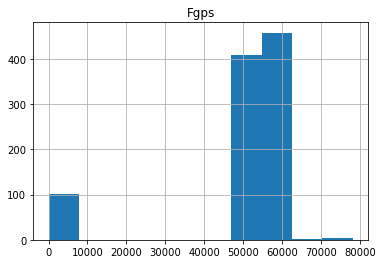

In [37]:
## Plotting the Fgps column.
import matplotlib.pyplot as plt
hist = ValidateDF.hist(column='Fgps')

<div class="alert alert-warning" role="alert">
  <strong>🔈  Note: 🔈 </strong>
    <br> Based on the previous plot you can realize that there were over 100 point with Zero value for Magnetic intensity. Having Zero values means that there were no Swarm points into the <strong>ST-Cylinder</strong> (see the MagGeo Main Notebook) for certain rows with specific date and time. This could be a common output when we use satellite data source, as the mission could have maintenance, calibration or other data processing chain issues. For  more information, you might want to check <a href="https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/operational-news">Swarm Operational News website</a>.
</div>

## Optional: Mapping the GPS Track using the annotated Magnetic Values

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see how the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

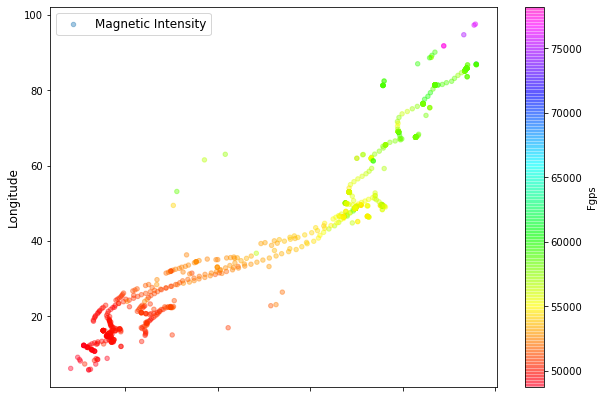

In [45]:
import matplotlib.pyplot as plt

GeoMagResults.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity",
    c="Fgps", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7)
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [46]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(GeoMagResults, geometry=geopandas.points_from_xy(GeoMagResults.Longitude, GeoMagResults.Latitude))
gdf.head()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist,geometry
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,25.704002,82.850591,21,327.950987,626.701218,POINT (68.30733 70.85472)
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,25.722557,82.844422,21,340.038476,628.953831,POINT (67.97505 70.83030)
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,25.673409,82.663410,26,348.223318,656.804069,POINT (67.75242 70.76172)
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,25.671765,82.643543,26,355.472899,657.901776,POINT (67.56198 70.68652)
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,25.759774,82.631119,26,355.980432,657.921513,POINT (67.54832 70.68545)


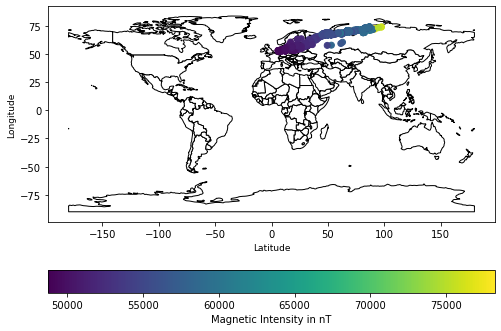

In [47]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world.plot(color='white', edgecolor='black', figsize = (8,6))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='Fgps', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)

plt.show()

Text(567.7954545454544, 0.5, 'Longitude')

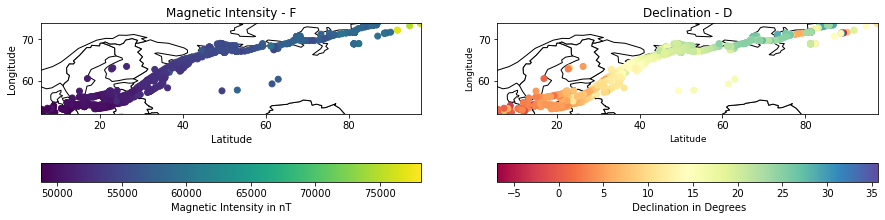

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,6))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='Fgps', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='D', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Declination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Declination - D')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')

## Exporting the final results to a CSV file

In [58]:
#Exporting the CSV file
os.chdir(r"./results")
outputfile ="GeoMag_"+gpsfilename
export_csv = GeoMagResults.to_csv (outputfile, index = None, header=True)